<a href="https://colab.research.google.com/github/Naomi-Ken-Korem/text-to-image-datatalks/blob/main/stable_diffusion_pipes_full_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image generation pipelines for Stable Diffusion using 🧨 Diffusers 

This notebook shows how to create a custom `diffusers` pipeline for text-to-image and text-guided image-to-image generation with Stable Diffusion model using  🤗 Hugging Face [🧨 Diffusers library](https://github.com/huggingface/diffusers). In the end you will implment an inpainting pipiline by yourself.

For a general introduction to the Stable Diffusion model please refer to this [colab](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_diffusion.ipynb).



##### Check cuda state

In [ ]:
!nvidia-smi

##### mount to your drive in case you want to load your own data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

##### diffusers git installation

In [ ]:
!pip install diffusers==0.7.2  transformers ftfy 

##### Getting SD model

You need to accept the model license before downloading or using the weights. In this post we'll use model version `v1-4`, so you'll need to  visit [its card](https://huggingface.co/CompVis/stable-diffusion-v1-4), read the license and tick the checkbox if you agree. 

You have to be a registered user in 🤗 Hugging Face Hub, and you'll also need to use an access token for the code to work. For more information on access tokens, please refer to [this section of the documentation](https://huggingface.co/docs/hub/security-tokens).

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

### Text to Image Generation

##### Load text to image pipeline. This should take around 2 minutes while all parts are downloaded: the VAE, clip model, latent diffusion model, and the safety content model. 

Lets look at the original basic text to image pipeline.
The pipeline contains:

**vae**: used to decode the latent space into a 512*512 image

**text_encoder**: CLIPTextModel,

**tokenizer**: CLIPTokenizer,

**unet**: UNet2DConditionModel the diffsuion model that converts noise to expressive latent code 

**scheduler**: sampling schdule, instead of sampling 1000 steps. 
we can preform jumps and still get good enough results.

**safety_checker**: StableDiffusionSafetyChecker - to avoid returning NSFW

**feature_extractor**: CLIPFeatureExtractor, servs as input to the safety checker

The whole pipeline is placed here in case you are curious, we will go deeper into all parts in the next cells
![model type diag](https://raw.githubusercontent.com/Naomi-Ken-Korem/text-to-image-datatalks/main/tti_pipe.png)


##### Text to image pipe implementation, you don't really need it, but you can take a look at the implementation

In [ ]:
import inspect
from typing import Callable, List, Optional, Union

import torch

from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer

from diffusers.configuration_utils import FrozenDict
from diffusers.models import AutoencoderKL, UNet2DConditionModel
from diffusers.pipeline_utils import DiffusionPipeline
from diffusers.schedulers import DDIMScheduler, LMSDiscreteScheduler, PNDMScheduler
from diffusers.utils import deprecate, logging
from diffusers.pipelines.stable_diffusion import StableDiffusionPipelineOutput
from diffusers.pipelines.stable_diffusion.safety_checker import StableDiffusionSafetyChecker
class StableDiffusionPipeline(DiffusionPipeline):
    r"""
    Pipeline for text-to-image generation using Stable Diffusion.
    This model inherits from [`DiffusionPipeline`]. Check the superclass documentation for the generic methods the
    library implements for all the pipelines (such as downloading or saving, running on a particular device, etc.)
    Args:
        vae ([`AutoencoderKL`]):
            Variational Auto-Encoder (VAE) Model to encode and decode images to and from latent representations.
        text_encoder ([`CLIPTextModel`]):
            Frozen text-encoder. Stable Diffusion uses the text portion of
            [CLIP](https://huggingface.co/docs/transformers/model_doc/clip#transformers.CLIPTextModel), specifically
            the [clip-vit-large-patch14](https://huggingface.co/openai/clip-vit-large-patch14) variant.
        tokenizer (`CLIPTokenizer`):
            Tokenizer of class
            [CLIPTokenizer](https://huggingface.co/docs/transformers/v4.21.0/en/model_doc/clip#transformers.CLIPTokenizer).
        unet ([`UNet2DConditionModel`]): Conditional U-Net architecture to denoise the encoded image latents.
        scheduler ([`SchedulerMixin`]):
            A scheduler to be used in combination with `unet` to denoise the encoded image latens. Can be one of
            [`DDIMScheduler`], [`LMSDiscreteScheduler`], or [`PNDMScheduler`].
        safety_checker ([`StableDiffusionSafetyChecker`]):
            Classification module that estimates whether generated images could be considered offensive or harmful.
            Please, refer to the [model card](https://huggingface.co/CompVis/stable-diffusion-v1-4) for details.
        feature_extractor ([`CLIPFeatureExtractor`]):
            Model that extracts features from generated images to be used as inputs for the `safety_checker`.
    """

    def __init__(
        self,
        vae: AutoencoderKL,
        text_encoder: CLIPTextModel,
        tokenizer: CLIPTokenizer,
        unet: UNet2DConditionModel,
        scheduler: Union[DDIMScheduler, PNDMScheduler, LMSDiscreteScheduler],
        safety_checker: StableDiffusionSafetyChecker,
        feature_extractor: CLIPFeatureExtractor,
    ):
        super().__init__()

        self.register_modules(
            vae=vae,
            text_encoder=text_encoder,
            tokenizer=tokenizer,
            unet=unet,
            scheduler=scheduler,
            safety_checker=safety_checker,
            feature_extractor=feature_extractor,
        )


    @torch.no_grad()
    def __call__(
        self,
        prompt: Union[str, List[str]],
        height: int = 512,
        width: int = 512,
        num_inference_steps: int = 50,
        guidance_scale: float = 7.5,
        negative_prompt: Optional[Union[str, List[str]]] = None,
        num_images_per_prompt: Optional[int] = 1,
        eta: float = 0.0,
        generator: Optional[torch.Generator] = None,
        latents: Optional[torch.FloatTensor] = None,
        output_type: Optional[str] = "pil",
        return_dict: bool = True,
        **kwargs,
    ):
        r"""
        Function invoked when calling the pipeline for generation.
        Args:
            prompt (`str` or `List[str]`):
                The prompt or prompts to guide the image generation.
            height (`int`, *optional*, defaults to 512):
                The height in pixels of the generated image.
            width (`int`, *optional*, defaults to 512):
                The width in pixels of the generated image.
            num_inference_steps (`int`, *optional*, defaults to 50):
                The number of denoising steps. More denoising steps usually lead to a higher quality image at the
                expense of slower inference.
            guidance_scale (`float`, *optional*, defaults to 7.5):
                Guidance scale as defined in [Classifier-Free Diffusion Guidance](https://arxiv.org/abs/2207.12598).
                `guidance_scale` is defined as `w` of equation 2. of [Imagen
                Paper](https://arxiv.org/pdf/2205.11487.pdf). Guidance scale is enabled by setting `guidance_scale >
                1`. Higher guidance scale encourages to generate images that are closely linked to the text `prompt`,
                usually at the expense of lower image quality.
            negative_prompt (`str` or `List[str]`, *optional*):
                The prompt or prompts not to guide the image generation. Ignored when not using guidance (i.e., ignored
                if `guidance_scale` is less than `1`).
            num_images_per_prompt (`int`, *optional*, defaults to 1):
                The number of images to generate per prompt.
            eta (`float`, *optional*, defaults to 0.0):
                Corresponds to parameter eta (η) in the DDIM paper: https://arxiv.org/abs/2010.02502. Only applies to
                [`schedulers.DDIMScheduler`], will be ignored for others.
            generator (`torch.Generator`, *optional*):
                A [torch generator](https://pytorch.org/docs/stable/generated/torch.Generator.html) to make generation
                deterministic.
            latents (`torch.FloatTensor`, *optional*):
                Pre-generated noisy latents, sampled from a Gaussian distribution, to be used as inputs for image
                generation. Can be used to tweak the same generation with different prompts. If not provided, a latents
                tensor will ge generated by sampling using the supplied random `generator`.
            output_type (`str`, *optional*, defaults to `"pil"`):
                The output format of the generate image. Choose between
                [PIL](https://pillow.readthedocs.io/en/stable/): `PIL.Image.Image` or `np.array`.
            return_dict (`bool`, *optional*, defaults to `True`):
                Whether or not to return a [`~pipelines.stable_diffusion.StableDiffusionPipelineOutput`] instead of a
                plain tuple.
        Returns:
            [`~pipelines.stable_diffusion.StableDiffusionPipelineOutput`] or `tuple`:
            [`~pipelines.stable_diffusion.StableDiffusionPipelineOutput`] if `return_dict` is True, otherwise a `tuple.
            When returning a tuple, the first element is a list with the generated images, and the second element is a
            list of `bool`s denoting whether the corresponding generated image likely represents "not-safe-for-work"
            (nsfw) content, according to the `safety_checker`.
        """

        if isinstance(prompt, str):
            batch_size = 1
        elif isinstance(prompt, list):
            batch_size = len(prompt)
        else:
            raise ValueError(f"`prompt` has to be of type `str` or `list` but is {type(prompt)}")

        if height % 8 != 0 or width % 8 != 0:
            raise ValueError(f"`height` and `width` have to be divisible by 8 but are {height} and {width}.")

        # get prompt text embeddings
        text_inputs = self.tokenizer(
            prompt,
            padding="max_length",
            max_length=self.tokenizer.model_max_length,
            return_tensors="pt",
        )
        text_input_ids = text_inputs.input_ids

        if text_input_ids.shape[-1] > self.tokenizer.model_max_length:
            removed_text = self.tokenizer.batch_decode(text_input_ids[:, self.tokenizer.model_max_length :])
            logger.warning(
                "The following part of your input was truncated because CLIP can only handle sequences up to"
                f" {self.tokenizer.model_max_length} tokens: {removed_text}"
            )
            text_input_ids = text_input_ids[:, : self.tokenizer.model_max_length]
        text_embeddings = self.text_encoder(text_input_ids.to(self.device))[0]

        # duplicate text embeddings for each generation per prompt, using mps friendly method
        bs_embed, seq_len, _ = text_embeddings.shape
        text_embeddings = text_embeddings.repeat(1, num_images_per_prompt, 1)
        text_embeddings = text_embeddings.view(bs_embed * num_images_per_prompt, seq_len, -1)

        # here `guidance_scale` is defined analog to the guidance weight `w` of equation (2)
        # of the Imagen paper: https://arxiv.org/pdf/2205.11487.pdf . `guidance_scale = 1`
        # corresponds to doing no classifier free guidance.
        do_classifier_free_guidance = guidance_scale > 1.0
        # get unconditional embeddings for classifier free guidance
        if do_classifier_free_guidance:
            uncond_tokens: List[str]
            if negative_prompt is None:
                uncond_tokens = [""]
            elif type(prompt) is not type(negative_prompt):
                raise TypeError(
                    f"`negative_prompt` should be the same type to `prompt`, but got {type(negative_prompt)} !="
                    f" {type(prompt)}."
                )
            elif isinstance(negative_prompt, str):
                uncond_tokens = [negative_prompt]
            elif batch_size != len(negative_prompt):
                raise ValueError(
                    f"`negative_prompt`: {negative_prompt} has batch size {len(negative_prompt)}, but `prompt`:"
                    f" {prompt} has batch size {batch_size}. Please make sure that passed `negative_prompt` matches"
                    " the batch size of `prompt`."
                )
            else:
                uncond_tokens = negative_prompt

            max_length = text_input_ids.shape[-1]
            uncond_input = self.tokenizer(
                uncond_tokens,
                padding="max_length",
                max_length=max_length,
                truncation=True,
                return_tensors="pt",
            )
            uncond_embeddings = self.text_encoder(uncond_input.input_ids.to(self.device))[0]

            # duplicate unconditional embeddings for each generation per prompt, using mps friendly method
            seq_len = uncond_embeddings.shape[1]
            uncond_embeddings = uncond_embeddings.repeat(batch_size, num_images_per_prompt, 1)
            uncond_embeddings = uncond_embeddings.view(batch_size * num_images_per_prompt, seq_len, -1)

            # For classifier free guidance, we need to do two forward passes.
            # Here we concatenate the unconditional and text embeddings into a single batch
            # to avoid doing two forward passes
            text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

        # get the initial random noise unless the user supplied it

        # Unlike in other pipelines, latents need to be generated in the target device
        # for 1-to-1 results reproducibility with the CompVis implementation.
        # However this currently doesn't work in `mps`.
        latents_shape = (batch_size * num_images_per_prompt, self.unet.in_channels, height // 8, width // 8)
        latents_dtype = text_embeddings.dtype
        if latents is None:
            if self.device.type == "mps":
                # randn does not exist on mps
                latents = torch.randn(latents_shape, generator=generator, device="cpu", dtype=latents_dtype).to(
                    self.device
                )
            else:
                latents = torch.randn(latents_shape, generator=generator, device=self.device, dtype=latents_dtype)
        else:
            if latents.shape != latents_shape:
                raise ValueError(f"Unexpected latents shape, got {latents.shape}, expected {latents_shape}")
            latents = latents.to(self.device)

        # set timesteps
        self.scheduler.set_timesteps(num_inference_steps)

        # Some schedulers like PNDM have timesteps as arrays
        # It's more optimized to move all timesteps to correct device beforehand
        timesteps_tensor = self.scheduler.timesteps.to(self.device)

        # scale the initial noise by the standard deviation required by the scheduler
        latents = latents * self.scheduler.init_noise_sigma

        # prepare extra kwargs for the scheduler step, since not all schedulers have the same signature
        # eta (η) is only used with the DDIMScheduler, it will be ignored for other schedulers.
        # eta corresponds to η in DDIM paper: https://arxiv.org/abs/2010.02502
        # and should be between [0, 1]
        accepts_eta = "eta" in set(inspect.signature(self.scheduler.step).parameters.keys())
        extra_step_kwargs = {}
        if accepts_eta:
            extra_step_kwargs["eta"] = eta

        for i, t in enumerate(self.progress_bar(timesteps_tensor)):
            # expand the latents if we are doing classifier free guidance
            latent_model_input = torch.cat([latents] * 2) 
            latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)

            # predict the noise residual
            noise_pred = self.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

            # perform guidance
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

            # compute the previous noisy sample x_t -> x_t-1
            latents = self.scheduler.step(noise_pred, t, latents, **extra_step_kwargs).prev_sample


        latents = 1 / 0.18215 * latents
        image = self.vae.decode(latents).sample

        image = (image / 2 + 0.5).clamp(0, 1)

        # we always cast to float32 as this does not cause significant overhead and is compatible with bfloa16
        image = image.cpu().permute(0, 2, 3, 1).float().numpy()

        if self.safety_checker is not None:
            safety_checker_input = self.feature_extractor(self.numpy_to_pil(image), return_tensors="pt").to(
                self.device
            )
            image, has_nsfw_concept = self.safety_checker(
                images=image, clip_input=safety_checker_input.pixel_values.to(text_embeddings.dtype)
            )
        else:
            has_nsfw_concept = None

        if output_type == "pil":
            image = self.numpy_to_pil(image)

        if not return_dict:
            return (image, has_nsfw_concept)

        return StableDiffusionPipelineOutput(images=image, nsfw_content_detected=has_nsfw_concept)

##### Create text to image instance and try in differnet prompts

In [ ]:
device = "cuda"
model_path = "CompVis/stable-diffusion-v1-4"
tti_pipe = StableDiffusionPipeline.from_pretrained(
    model_path,
    revision="fp16", 
    torch_dtype=torch.float16,
    use_auth_token=True
)
tti_pipe = tti_pipe.to(device)


Once the pipeline is loaded you can start generate images from prompts, Here are couple of exampels:

  0%|          | 0/51 [00:00<?, ?it/s]

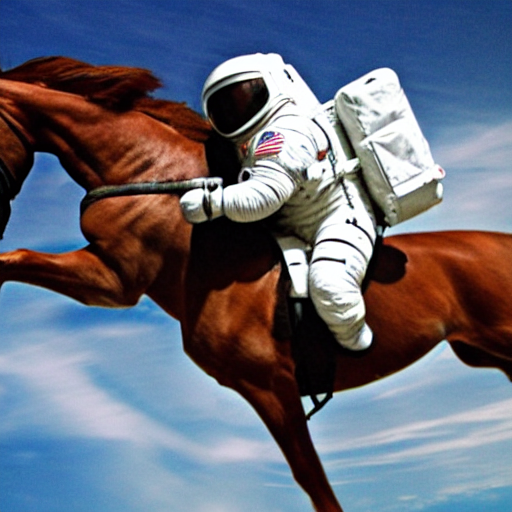

In [ ]:
prompt = "a photograph of an astronaut riding a horse"
# with autocast("cuda"):
image = tti_pipe(prompt).images[0]  
image #display result

Run same text prompt with different style words and see how strong it effects the results. You can use different artist names, or different image stylisitc descriptions (photorealism, modernism etc)

  0%|          | 0/51 [00:00<?, ?it/s]

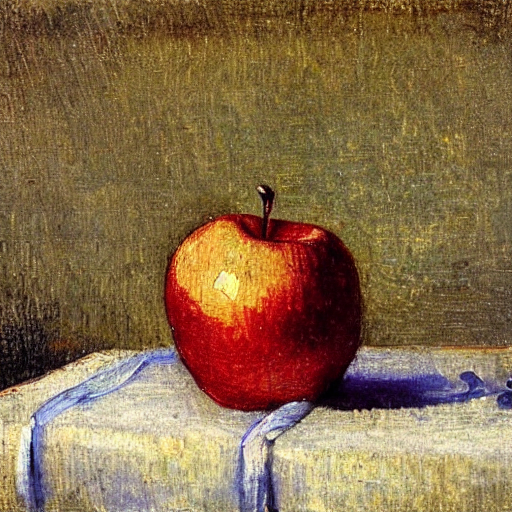

In [ ]:
prompt = "a vangoch creation of an apple in the middle of an acurate table" #Your text goes here: change the prompt to try different image styles
image = tti_pipe(prompt).images[0] 
image #display result

  0%|          | 0/51 [00:00<?, ?it/s]

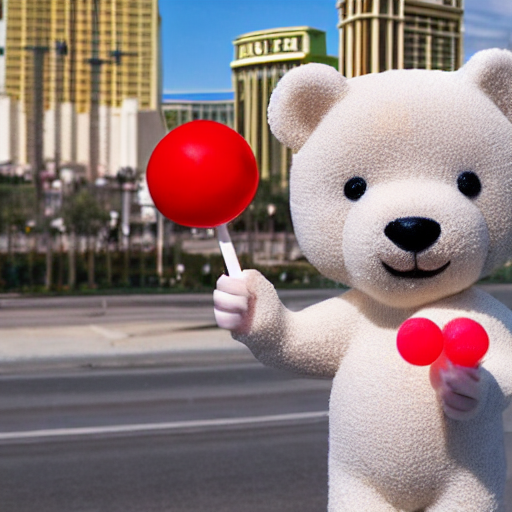

In [ ]:
prompt = "a realistic photograph of a white bear holding a lolypop looking at a NFO in the middle of Las vegas"
image = tti_pipe(prompt).images[0]  
image #display result

#### **Guidance Scale**

Now Try to change the guidance scale parameter to see its importance, try to set values between 1-15.
![model type diag](https://raw.githubusercontent.com/Naomi-Ken-Korem/text-to-image-datatalks/main/images/guidance_scale.png)

In [ ]:
prompt = "a realistic photograph of a white bear holding a lolypop looking at a NFO in the middle of Las vegas"
image = tti_pipe(prompt, guidance_scale=1.1).images[0]  
image 

### Image to Image Generation

#####Now lets see the Image to Image pipleline:
![model type diag](https://raw.githubusercontent.com/Naomi-Ken-Korem/text-to-image-datatalks/main/images/image-to-image-pipe.png)

In [ ]:
import PIL
import numpy as np
import torch
from diffusers import StableDiffusionImg2ImgPipeline




When loading image to image pipe, instead of downloading all models again, lets use the models that were already used in the text to image pipe

In [ ]:
iti_pipe = StableDiffusionImg2ImgPipeline(
    vae=tti_pipe.vae,
    text_encoder=tti_pipe.text_encoder,
    tokenizer=tti_pipe.tokenizer,
    unet=tti_pipe.unet,
    scheduler=tti_pipe.scheduler,
    safety_checker=tti_pipe.safety_checker,
    feature_extractor=tti_pipe.feature_extractor,
)

iti_pipe = iti_pipe.to(device)


Download an initial image and preprocess it so we can pass it to the pipeline.

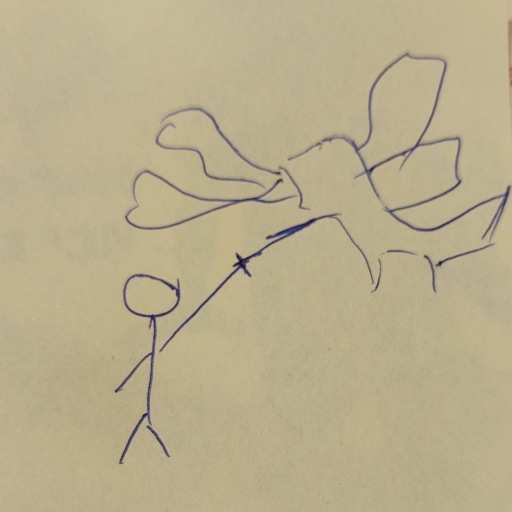

In [ ]:
import requests
from io import BytesIO
from PIL import Image

url = 'https://raw.githubusercontent.com/Naomi-Ken-Korem/text-to-image-datatalks/main/images/sketch.png'
response = requests.get(url)
init_image_pil = Image.open(BytesIO(response.content)).convert('RGB')
init_image_pil = init_image_pil.resize((512, 512))
init_image_pil

Define the prompt and run the pipeline. Try to change the strength values to see its effect, textual prompts and and original image (segmentaiton map, sketch, image)

  0%|          | 0/46 [00:00<?, ?it/s]

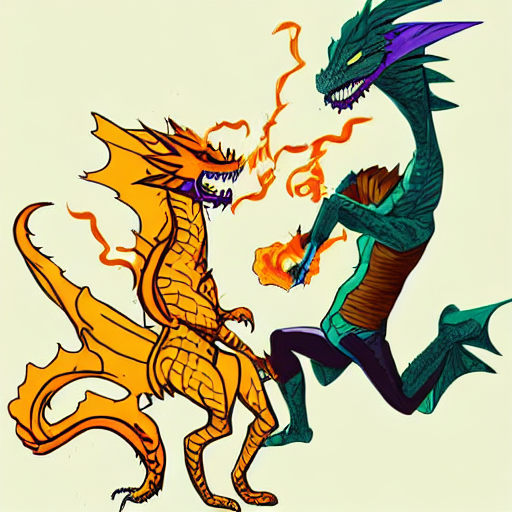

In [ ]:
prompt = "A  hero fighting a dragon that splits fire all over art very coherent and colorful high contrast,  dark shadows, hard lighting"
image = iti_pipe(prompt=prompt, init_image=init_image_pil, strength=0.9, guidance_scale=7.5, generator=generator).images[0]
image

You can try to load another image and run it with the iamge to image pipe

### Inpainting

#####Now lets implement the inpainting pipelie, using the bascis that we already have
![model type diag](https://raw.githubusercontent.com/Naomi-Ken-Korem/text-to-image-datatalks/main/images/inpainting-pipe.png)

in order to use the model, you need to accept the model license before downloading or using the weights. In this post we'll use `runwayml/stable-diffusion-inpainting` model released by Runwayml so you'll need to  visit [its card](https://huggingface.co/runwayml/stable-diffusion-inpainting), read the license and tick the checkbox if you agree. 

You have to be a registered user in 🤗 Hugging Face Hub, and you'll also need to use an access token for the code to work. For more information on access tokens, please refer to [this section of the documentation](https://huggingface.co/docs/hub/security-tokens).

In [ ]:
import PIL
import requests
import torch
from io import BytesIO

from diffusers import StableDiffusionInpaintPipeline



pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting",
    revision="fp16",
    torch_dtype=torch.float16,
)
pipe = pipe.to("cuda")


#####Full inpainting pipeline, places here due to versions incompatability

#####Load last implementation of inpainiting pipe

In [ ]:
import inspect
from typing import List, Optional, Union

import numpy as np
import torch

import PIL
from diffusers import StableDiffusionInpaintPipeline
inpaint_pipe = StableDiffusionInpaintPipeline(
    vae=pipe.vae,
    text_encoder=pipe.text_encoder,
    tokenizer=pipe.tokenizer,
    unet=pipe.unet,
    scheduler=pipe.scheduler,
    safety_checker=pipe.safety_checker,
    feature_extractor=pipe.feature_extractor,
)

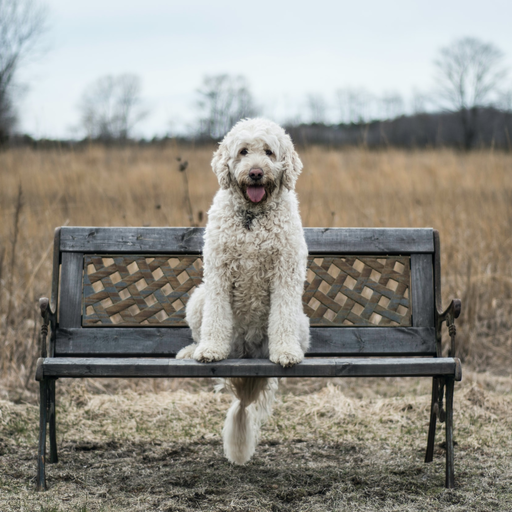

In [ ]:
import requests
import PIL
from io import BytesIO
prompt = "Face of a yellow cat, high resolution, sitting on a park bench"
img_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"
mask_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png"

def download_image(url):
    response = requests.get(url)
    return PIL.Image.open(BytesIO(response.content)).convert("RGB")

init_image = download_image(img_url).resize((512, 512))
mask_image = download_image(mask_url).resize((512, 512))

init_image

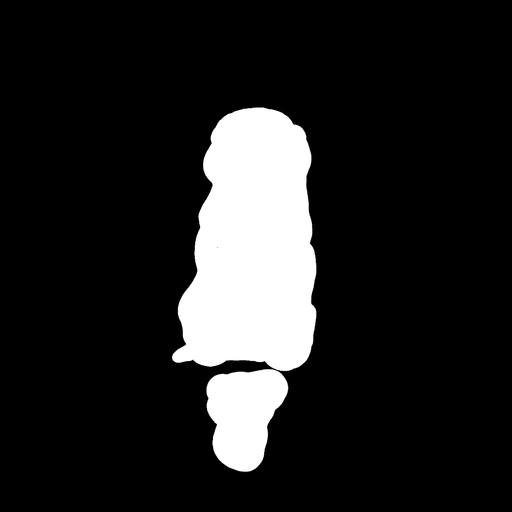

In [ ]:
mask_image

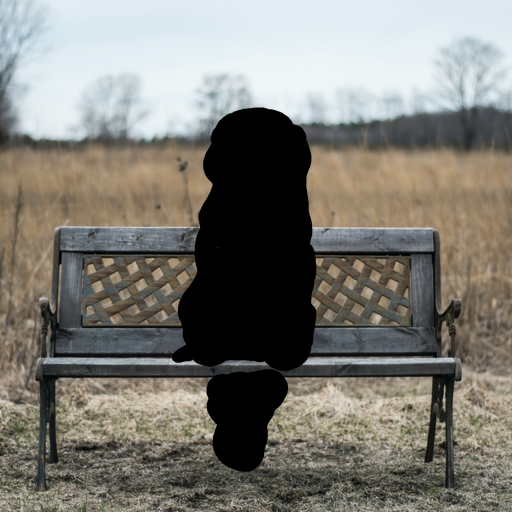

In [ ]:
import numpy as np
im = (1 - np.array(mask_image)/255) * np.array(init_image)
PIL.Image.fromarray(np.clip(im, 0, 255).astype('uint8'))

  0%|          | 0/50 [00:00<?, ?it/s]

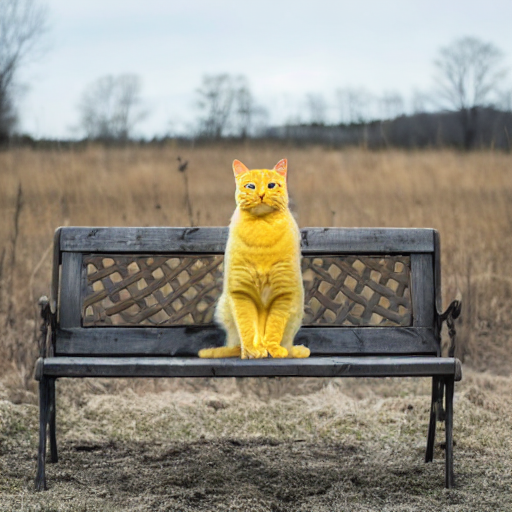

In [ ]:
|image = inpaint_pipe(prompt=prompt, image=init_image, mask_image=mask_image).images[0]
image

  0%|          | 0/50 [00:00<?, ?it/s]

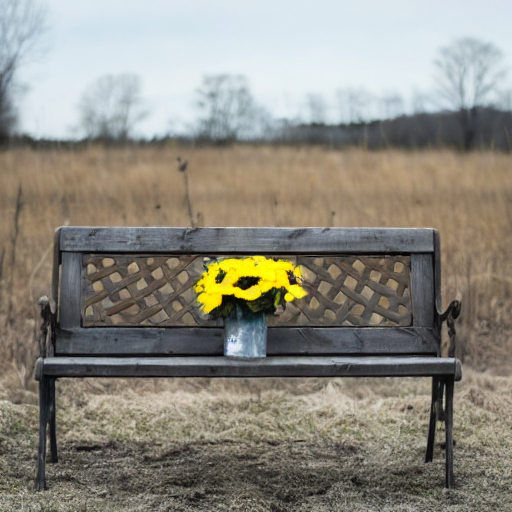

In [ ]:
prompt = "a flower on the bench"
image = inpaint_pipe(prompt=prompt, image=init_image, mask_image=mask_image).images[0]
image

### Editing images using stable diffusion

Here we will see how we can get some control over the generated results

In [ ]:
#here are all possible schedulers, you can try change them in the pipe constructor
#cirrent defualt is PNDMScheduler 
from diffusers.schedulers import (
    DDIMScheduler,
    EulerAncestralDiscreteScheduler,
    EulerDiscreteScheduler,
    LMSDiscreteScheduler,
    PNDMScheduler,
)

In [ ]:
from diffusers import StableDiffusionImg2ImgPipeline

generator = torch.Generator(device=device).manual_seed(1000)


iti_pipe2 = StableDiffusionImg2ImgPipeline(
    vae=tti_pipe.vae,
    text_encoder=tti_pipe.text_encoder,
    tokenizer=tti_pipe.tokenizer,
    unet=tti_pipe.unet,
    scheduler=tti_pipe.scheduler,
    safety_checker=tti_pipe.safety_checker,
    feature_extractor=tti_pipe.feature_extractor,
)

iti_pipe2 = iti_pipe2.to(device)



Load your favorite image

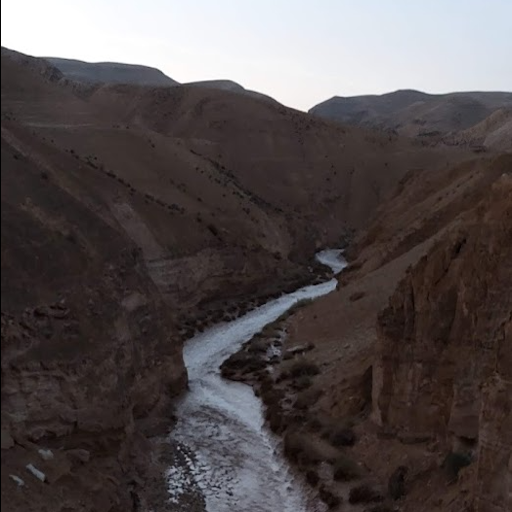

In [ ]:
url = 'https://raw.githubusercontent.com/Naomi-Ken-Korem/text-to-image-datatalks/main/images/desert.png'
response = requests.get(url)
init_image_pil = Image.open(BytesIO(response.content)).convert('RGB')
init_image_pil = init_image_pil.resize((512, 512))
init_image_pil

And lets try to edit it a bit

  0%|          | 0/50 [00:00<?, ?it/s]

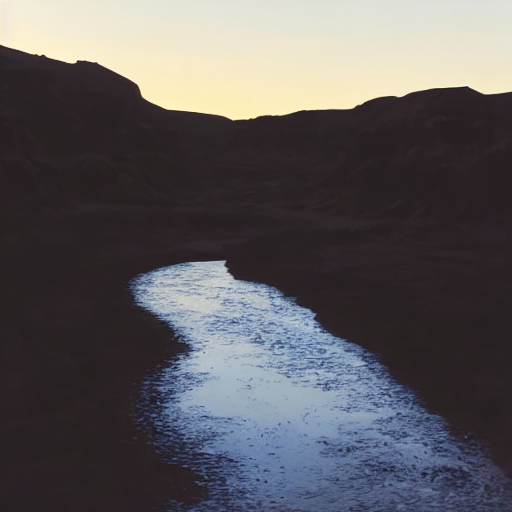

In [ ]:
prompt = "a river in the desert and birds flying in the sky"

image = iti_pipe2(prompt=prompt, 
                  init_image=init_image_pil, 
                  strength=0.99, 
                  guidance_scale=7.5, 
                  generator=generator).images[0]
image

Results are nice, but In most cases I see no birds.

Lets try a different text prompt


  0%|          | 0/46 [00:00<?, ?it/s]

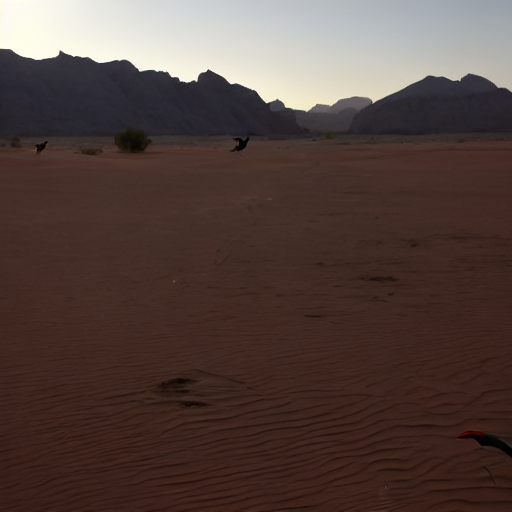

In [ ]:
prompt = "red river in the desert and birds flying in the sky"

image = iti_pipe2(prompt=prompt, 
                  init_image=init_image_pil, 
                  strength=0.9, 
                  guidance_scale=7.5, 
                  num_inference_step=100,
                  generator=generator).images[0]
image

Ok, this is better? but still no what I mentioned.
Lets try to help the model with some sketch.
I am using https://www.photopea.com/ to edit a but my images.
You can load an image, add a layer and draw on the image

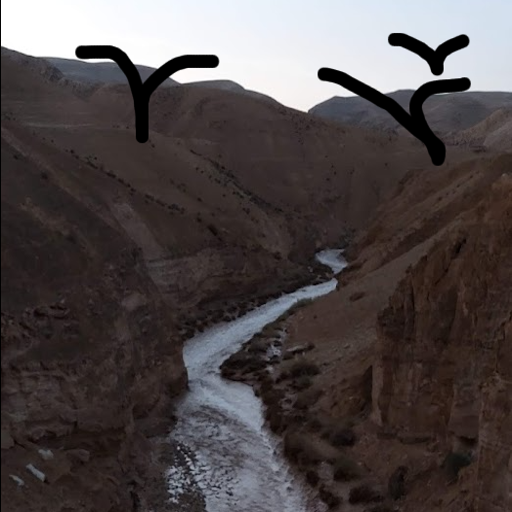

In [ ]:
url = 'https://raw.githubusercontent.com/Naomi-Ken-Korem/text-to-image-datatalks/main/images/desert_with_birds_sketch.png'
response = requests.get(url)

init_image_pil = Image.open(BytesIO(response.content)).convert('RGB')
init_image_pil = init_image_pil.resize((512, 512))
init_image_pil

  0%|          | 0/46 [00:00<?, ?it/s]

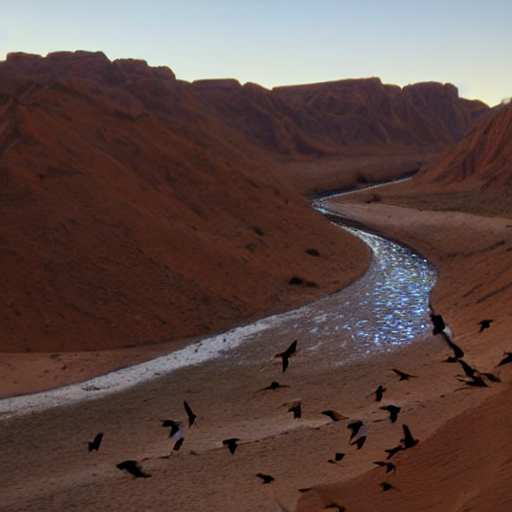

In [ ]:
prompt = "a river in the desert and birds flying in the sky"

image = iti_pipe2(prompt=prompt, 
                  init_image=init_image_pil, 
                  strength=0.9, 
                  guidance_scale=7.5, 
                  num_inference_step=100,
                  generator=generator).images[0]
image

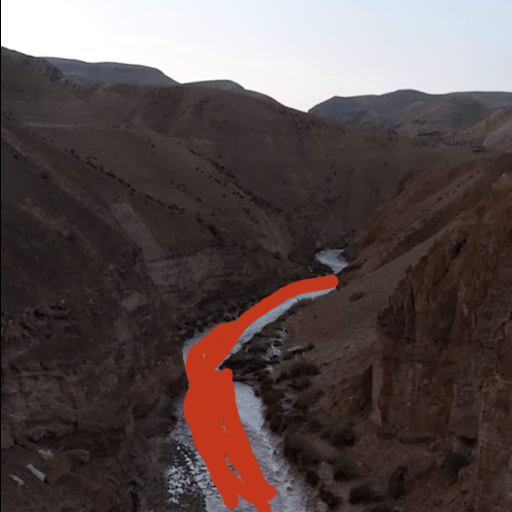

In [ ]:
url = 'https://raw.githubusercontent.com/Naomi-Ken-Korem/text-to-image-datatalks/main/images/desert_with_red_river.png'
response = requests.get(url)
init_image_pil = Image.open(BytesIO(response.content)).convert('RGB')
init_image_pil = init_image_pil.resize((512, 512))
init_image_pil

  0%|          | 0/31 [00:00<?, ?it/s]

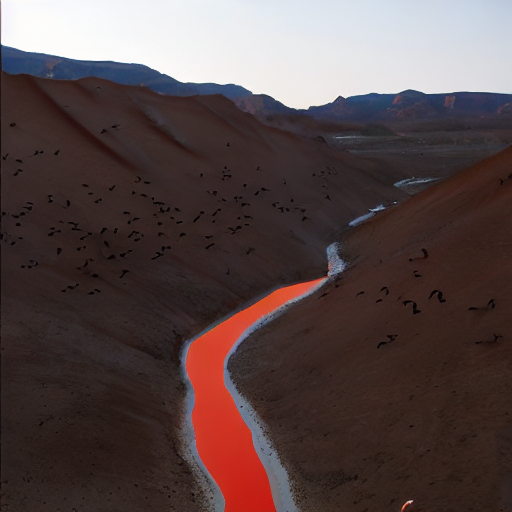

In [ ]:
prompt = "red river in the desert and birds flying in the sky"

image = iti_pipe2(prompt=prompt, 
                  init_image=init_image_pil, 
                  strength=0.6, 
                  guidance_scale=7.5, 
                  num_inference_step=100,
                  generator=generator).images[0]
image

Note that you can play with the strength value. and the results will be really effected

